<a href="https://colab.research.google.com/github/alantai26/DS3000-Final-Project/blob/main/Phase_III_REDACTED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Akshat Vij
- Becky Zheng
- Alan Tai
- Arvind Narayan


In [ ]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import time
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import pandas as pd
import numpy as np
import requests
import time

# 1. SETUP API KEYS (List for rotation)
api_keys = ['2JBQZLXM8OCM27D2', 'T0PV308RLKKA833B']
current_key_index = 0

# 2. DEFINE STOCKS
stocks_by_sector = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'TSLA'],
    'Healthcare': ['JNJ', 'UNH', 'PFE', 'ABBV', 'TMO', 'DHR'],
    'Financial': ['JPM', 'BAC', 'WFC', 'GS', 'MS', 'C'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC'],
    'Consumer': ['AMZN', 'WMT', 'DIS', 'TGT', 'LOW', 'COST']
}

# Flatten to get list
all_stocks = []
for sector, tickers in stocks_by_sector.items():
    for ticker in tickers:
        all_stocks.append({'Ticker': ticker, 'Sector': sector})

# Master list to hold EVERY row of data
all_daily_data = []

print(f"Starting collection for {len(all_stocks)} stocks...")

for stock_info in all_stocks:
    ticker = stock_info['Ticker']
    sector = stock_info['Sector']

    api_key = api_keys[current_key_index]

    try:
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&outputsize=full&apikey={api_key}'

        response = requests.get(url)
        data = response.json()

        if "Note" in data or "Information" in data:
            print(f"Limit hit on Key {current_key_index+1}. Switching keys...")
            current_key_index = (current_key_index + 1) % len(api_keys)
            time.sleep(5)

            print(f"Skipping {ticker} due to limit. Re-run or add retry logic.")
            continue

        if 'Time Series (Daily)' in data:
            time_series = data['Time Series (Daily)']

            for date, values in time_series.items():

                row = {
                    'Date': date,
                    'Ticker': ticker,
                    'Sector': sector,
                    'Close': float(values['4. close']),
                    'Volume': float(values['5. volume']),
                    'High': float(values['2. high']),
                    'Low': float(values['3. low']),
                }
                all_daily_data.append(row)

            print(f"Collected {len(time_series)} rows for {ticker}")

        else:
            print(f"No data for {ticker}. Response keys: {list(data.keys())}")
        time.sleep(12)

    except Exception as e:
        print(f"Failed to collect {ticker}: {e}")

df = pd.DataFrame(all_daily_data)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])

df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()

df['Daily_Range'] = df['High'] - df['Low']

df = df.dropna()

print(f"Total Rows Collected: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())

df.to_csv('stock_sector_full_data.csv', index=False)
print("\nSaved to 'stock_sector_full_data.csv'")

Starting collection for 30 stocks...
Limit hit on Key 1. Switching keys...
Skipping AAPL due to limit. Re-run or add retry logic.
Limit hit on Key 2. Switching keys...
Skipping MSFT due to limit. Re-run or add retry logic.
Limit hit on Key 1. Switching keys...


KeyboardInterrupt: 

## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np

In [ ]:
# load raw daily data
df = pd.read_csv("stock_all_dataset.csv")

def preprocess_data(df):
  '''
  Prepares the data by cleaning necessary columns. It
  - ensures that the Date column is in datetime format
  - computes daily return (percent change in closing price) if it is missing
  - computes daily price range (high-low) if missing
  - converts numeric columns to proper types
  - removes rows with missing or invalid values

  Returns:
  - a clenaed DataFrame ready to be aggregated and used for modeling.
  '''

  # make sure Date is datetime
  df['Date'] = pd.to_datetime(df['Date'])

  # compute Daily_Return and Daily_Range if not already
  if 'Daily_Return' not in df.columns:
    df = df.sort_values(by=['Ticker', 'Date'])
    df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()

  if 'Daily_Range' not in df.columns:
    df['Daily_Range'] = df['High'] - df['Low']

  # make sure numeric columns are correct/good
  numeric_cols = ['Close', 'Volume', 'High', 'Low', 'Daily_Return', 'Daily_Range']
  df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

  df = df.dropna()

  return df

df = preprocess_data(df)


In [ ]:
df['YearWeek'] = df['Date'].dt.strftime('%Y-%U') # for example, '2024-03' means week 3 of 2024
# aggregate to weekly features per (Ticker, Sector, YearWeek)
weekly_df = df.groupby(['Ticker', 'Sector', 'YearWeek']).agg(
    Weekly_Volatility=('Daily_Return', 'std'),
    Weekly_Avg_Volume=('Volume', 'mean'),
    Weekly_Avg_Close=('Close', 'mean'),
    Weekly_Price_Range=('Daily_Range', 'mean'),
    Days_In_Week=('Daily_Return', 'count')
).reset_index()

# get rid of any NaNs
weekly_df = weekly_df.dropna(subset=[
    'Weekly_Volatility', 'Weekly_Avg_Volume', 'Weekly_Avg_Close', 'Weekly_Price_Range'
])

print("Weekly rows:", len(weekly_df))
print(weekly_df.head())

# save as csv to use later
weekly_df.to_csv("stock_sector_weekly_ml_ready.csv", index=False)



Weekly rows: 38133
  Ticker      Sector YearWeek  Weekly_Volatility  Weekly_Avg_Volume  \
0   AAPL  Technology  1999-44           0.017187          3400875.0   
1   AAPL  Technology  1999-45           0.058790          5155240.0   
2   AAPL  Technology  1999-46           0.020072          2742200.0   
3   AAPL  Technology  1999-47           0.019935          2439400.0   
4   AAPL  Technology  1999-48           0.027858          5609260.0   

   Weekly_Avg_Close  Weekly_Price_Range  Days_In_Week  
0            83.420              3.9375             4  
1            92.060              5.9980             5  
2            90.588              3.9720             5  
3            93.295              3.4850             4  
4           104.136              5.9760             5  


### Attempt 1 - Linear Regression

In [ ]:
# use aggregated data for ML
df_ml = weekly_df

X = df_ml[['Weekly_Avg_Volume', 'Weekly_Avg_Close', 'Weekly_Price_Range']].values
y = df_ml['Weekly_Volatility'].values

def normalize(X):
  ''' Standardizes the feature matrix so each column has mean = 0
  and standard deviation = 1
  '''
  return (X - X.mean(axis=0)) / X.std(axis=0)

X = normalize(X)

# split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
def linear_regression_np(X, y):
  ''' Fits a linear regression model using the Normal Equation.

  This function adds a bias column of 1s to the feature matrix and solves
  for the optimal weight vector.

  Returns:
    theta: the learned coefficients for the linear regression model
  '''
  # add bias term to feature matrix
  X = np.c_[np.ones(len(X)), X]

  # compute optimal wieght vector using Normal Equation
  theta = np.linalg.inv(X.T @ X) @ X.T @ y
  return theta

In [ ]:
def predict_numpy(X, theta):
  ''' Uses the learned parameters to generate predictions

  This function adds a bias col of 1s to the feature matrix and computes
  predictions using matrix multiplication.

  Returns:
    A vector of predicted values.

  '''
  # add bias
  X = np.c_[np.ones(len(X)), X]
  return X @ theta

In [ ]:
theta = linear_regression_np(X_train, y_train)
y_pred = predict_numpy(X_test, theta)

mse = np.mean((y_test - y_pred)**2)
r2 = 1 - (mse / np.var(y_test))
print("Weekly MSE: ", mse)
print("Weekly R2:", r2)

Weekly MSE:  0.0002059966562284461
Weekly R2: 0.20902740764629024


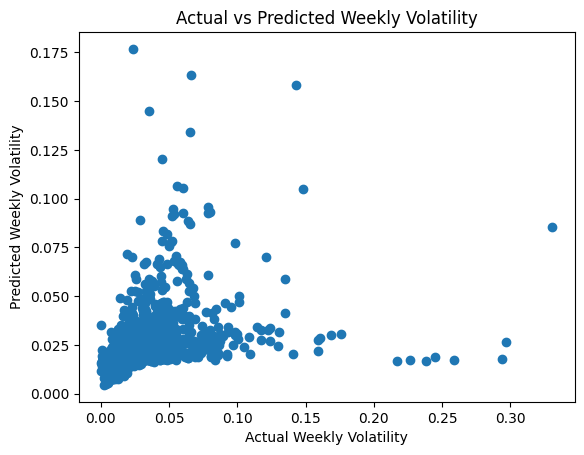

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Weekly Volatility")
plt.ylabel("Predicted Weekly Volatility")
plt.title("Actual vs Predicted Weekly Volatility")
plt.show()

### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [ ]:
df_ml = pd.read_csv('stock_sector_weekly_ml_ready.csv')

X = df_ml[['Weekly_Avg_Volume', 'Weekly_Avg_Close', 'Weekly_Price_Range']].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
poly = PolynomialFeatures(degree=4, include_bias=True)
X_poly = poly.fit_transform(X_scaled)

print("Number of polynomial features:", X_poly.shape[1])

Number of polynomial features: 35


In [ ]:
split = int(0.8 * len(X_poly))
X_train, X_test = X_poly[:split], X_poly[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
def ridge_regression_np(X, y, lam=0.1):
    """Stable ridge-regularized normal equation."""
    I = np.eye(X.shape[1])
    theta = np.linalg.inv(X.T @ X + lam * I) @ X.T @ y
    return theta

In [ ]:
def predict_numpy(X, theta):
    return X @ theta

In [ ]:
theta_poly = ridge_regression_np(X_train, y_train, lam=0.1)

# Prediction
y_pred_poly = predict_numpy(X_test, theta_poly)

In [ ]:
mse_poly = np.mean((y_test - y_pred_poly)**2)
r2_poly = 1 - mse_poly / np.var(y_test)

print("MSE:", mse_poly)
print("R²:", r2_poly)

MSE: 0.0002516686823867996
R²: 0.033658925507157544


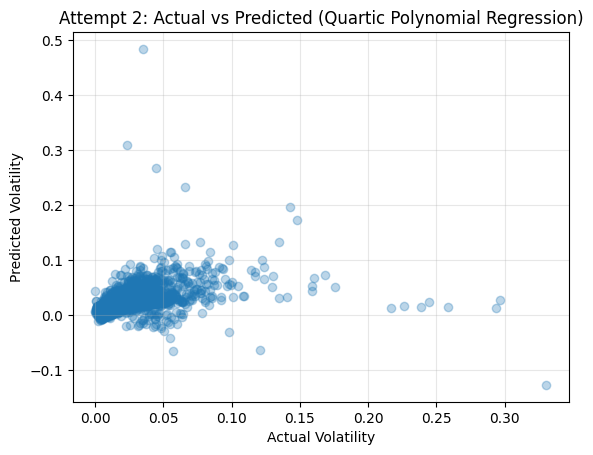

In [ ]:
plt.scatter(y_test, y_pred_poly, alpha=0.3)
plt.xlabel("Actual Volatility")
plt.ylabel("Predicted Volatility")
plt.title("Attempt 2: Actual vs Predicted (Quartic Polynomial Regression)")
plt.grid(alpha=0.3)
plt.show()

#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from Part 1.1 and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function.

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def line_of_best_fit(X, y):
    """
    Calculates the linear regression weights using the Normal Equation.

    Args:
        X (array): The input feature matrix of shape
        y (array): The target values vector of shape

    Returns:
        weights (array): The optimal weights (coefficients) for the linear model.
    """

    weights = np.linalg.inv(X.T @ X) @ X.T @ y
    return weights

def linreg_predict(X, y, weights):
    """
    Predicts target values and calculates performance metrics

    Args:
        X (array): The input feature matrix of shape (n_samples, n_features).
        y (array): The actual target values of shape (n_samples).
        weights (array): The learned weights of the model of shape (n_features).

    Returns:
        finished_dict (dict):
          - 'mse' (float): Mean Squared Error of the predictions.
          - 'r2' (float): R-squared (coefficient of determination) score.
          - 'predictions' (array): The predicted target values.
    """

    y_pred = X @ weights

    mse = np.mean((y - y_pred)**2)

    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot)

    finished_dict = {'mse': mse, 'r2': r2, 'predictions': y_pred}

    return finished_dict

df = pd.read_csv('stock_sector_weekly_ml_ready.csv')

X_features = ['Weekly_Avg_Volume', 'Weekly_Avg_Close', 'Weekly_Price_Range']
X_raw = df[X_features].values

y = df['Weekly_Volatility'].values

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Poloynomial Features
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X_scaled)

print(f"Feature shape changed from {X_raw.shape} to {X_poly.shape}")

# Cross Validation
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_poly, y, test_size=0.3, random_state=50
)

best_fit_weights = line_of_best_fit(Xtrain, ytrain)

results = linreg_predict(Xtest, ytest, best_fit_weights)

print(f"Cross-Validated MSE: {results['mse']:.6f}")
print(f"Cross-Validated R2:  {results['r2']:.6f}")

Feature shape changed from (38133, 3) to (38133, 10)
Cross-Validated MSE: 0.000219
Cross-Validated R2:  0.234937


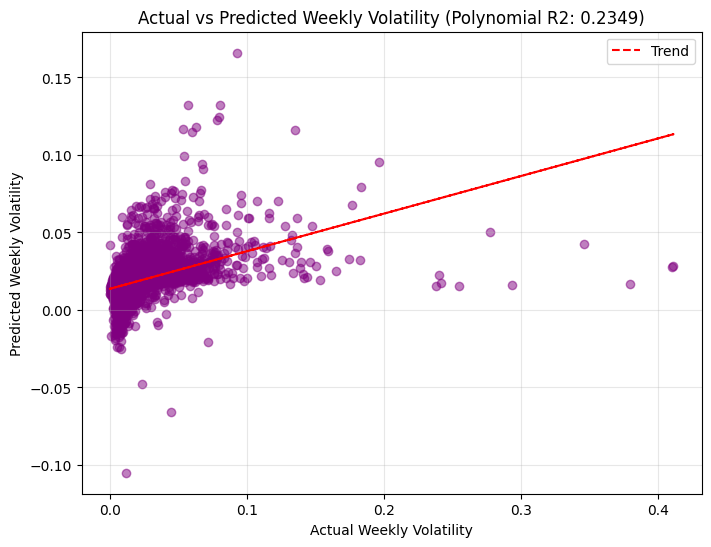

In [ ]:
import matplotlib.pyplot as plt

y_pred_poly = results['predictions']

plt.figure(figsize=(8, 6))

plt.scatter(ytest, y_pred_poly, alpha=0.5, color='purple')

plt.xlabel("Actual Weekly Volatility")
plt.ylabel("Predicted Weekly Volatility")
plt.title(f"Actual vs Predicted Weekly Volatility (Polynomial R2: {results['r2']:.4f})")

m, b = np.polyfit(ytest, y_pred_poly, 1)
plt.plot(ytest, m*ytest + b, color='red', linestyle='--', label='Trend')
plt.legend()

plt.grid(True, alpha=0.3)
plt.show()

### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

$$
y = b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4 + b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3
$$

Where:

- $y$: trip duration
- $x_1$: time of day
- $x_2$: member or casual (1 or 0)
- $x_3$: electric or classic bike (1 or 0)

- Polynomial terms $b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4$
- Interaction terms with dummy variables $b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3$

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Loading the dataset
df_ml = pd.read_csv('stock_sector_weekly_ml_ready.csv')

In [ ]:
# Creating dummy variables
df_with_dummies = pd.get_dummies(df, columns=['Sector'], drop_first=True)

sector_cols = [col for col in df_with_dummies.columns if 'Sector_' in col]

print(f"New sector columns: {sector_cols}")
print("First few rows with dummies:")
print(df_with_dummies.head())

New sector columns: ['Sector_Energy', 'Sector_Financial', 'Sector_Healthcare', 'Sector_Technology']
First few rows with dummies:
  Ticker YearWeek  Weekly_Volatility  Weekly_Avg_Volume  Weekly_Avg_Close  \
0   AAPL  1999-44           0.017187          3400875.0            83.420   
1   AAPL  1999-45           0.058790          5155240.0            92.060   
2   AAPL  1999-46           0.020072          2742200.0            90.588   
3   AAPL  1999-47           0.019935          2439400.0            93.295   
4   AAPL  1999-48           0.027858          5609260.0           104.136   

   Weekly_Price_Range  Days_In_Week  Sector_Energy  Sector_Financial  \
0              3.9375             4          False             False   
1              5.9980             5          False             False   
2              3.9720             5          False             False   
3              3.4850             4          False             False   
4              5.9760             5          Fal

In [ ]:
# Main 3 numerical features
numerical_cols = ['Weekly_Avg_Volume', 'Weekly_Avg_Close', 'Weekly_Price_Range']

# Sector dummy variables
sector_cols = [col for col in df_with_dummies.columns if col.startswith('Sector_')]

# Combing Sector dummy varaibles and Numerical Features
all_features = numerical_cols + sector_cols

# X is our features that we use to predict
X = df_with_dummies[all_features].copy()

# y = is our prediction (volatility)
y = df_with_dummies['Weekly_Volatility']

print(f"Total features: {len(all_features)}")
print(f"  - Numerical Feautes: {len(numerical_cols)}")
print(f"  - Sector dummies: {len(sector_cols)}")
print(f"Feature names: {all_features}")

Total features: 7
  - Numerical Feautes: 3
  - Sector dummies: 4
Feature names: ['Weekly_Avg_Volume', 'Weekly_Avg_Close', 'Weekly_Price_Range', 'Sector_Energy', 'Sector_Financial', 'Sector_Healthcare', 'Sector_Technology']


In [ ]:
# Scalling all the numbers by standardizing them
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("Standardized features:")
print(X.head())

Standardized features:
   Weekly_Avg_Volume  Weekly_Avg_Close  Weekly_Price_Range  Sector_Energy  \
0          -0.324909         -0.213303            0.088911          False   
1          -0.285510         -0.181384            0.373370          False   
2          -0.339702         -0.186822            0.093674          False   
3          -0.346502         -0.176821            0.026442          False   
4          -0.275313         -0.136770            0.370333          False   

   Sector_Financial  Sector_Healthcare  Sector_Technology  
0             False              False               True  
1             False              False               True  
2             False              False               True  
3             False              False               True  
4             False              False               True  


In [ ]:
# We will create terms till degree = 3(x, x^2, x^3)
poly = PolynomialFeatures(degree=3, include_bias=False)

# Transforming the features
X_poly = poly.fit_transform(X)

print(f"Original features: {X.shape[1]}")
print(f"After polynomial transformation: {X_poly.shape[1]}")

Original features: 7
After polynomial transformation: 119


In [ ]:
# Spliting 80% of data for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 30506
Testing samples: 7627


In [ ]:
# Using Ridge regression (this helps prevent overfitting)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

print(f"Model trained on {len(X_train)} samples")
print(f"Using {X_train.shape[1]} features")

Model trained on 30506 samples
Using 119 features


In [ ]:
# Our prediction for y
y_pred = model.predict(X_test)

# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"This means our model explains {r2*100:.1f}% of the variance")


Mean Squared Error (MSE): 0.000129
R-squared (R²): 0.4458
This means our model explains 44.6% of the variance


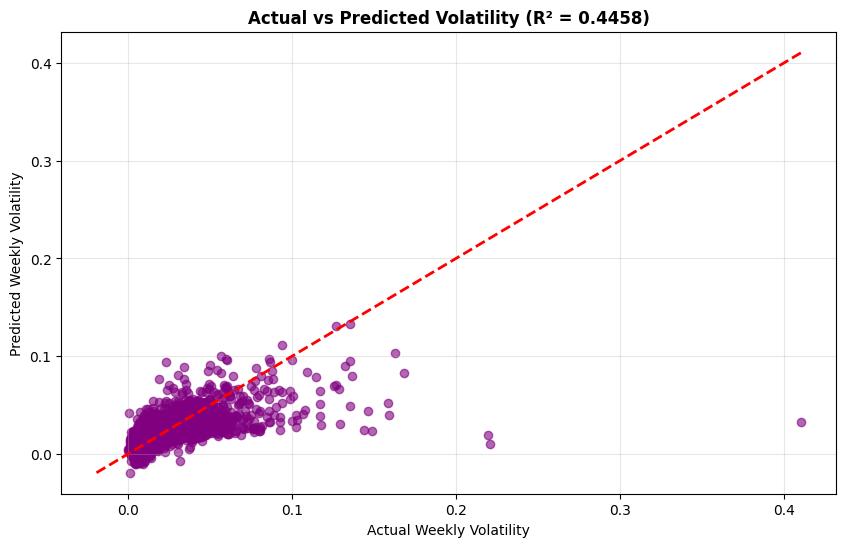

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')

# Adding a diagonal line (y=mx+b)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prediction line')

plt.xlabel('Actual Weekly Volatility')
plt.ylabel('Predicted Weekly Volatility')
plt.title(f'Actual vs Predicted Volatility (R² = {r2:.4f})', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
feature_names = poly.get_feature_names_out(all_features)

# Create a dataframe of coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("Top 15 Most Important Features:")
print(coef_df.head(15).to_string(index=False))

Top 15 Most Important Features:
                                               Feature  Coefficient  Abs_Coefficient
                      Weekly_Avg_Close^2 Sector_Energy     0.086609         0.086609
     Weekly_Avg_Close Weekly_Price_Range Sector_Energy    -0.084863         0.084863
   Weekly_Avg_Volume Weekly_Avg_Close Sector_Financial     0.062589         0.062589
                                    Weekly_Price_Range     0.052438         0.052438
                                      Weekly_Avg_Close    -0.052173         0.052173
                    Weekly_Avg_Volume Weekly_Avg_Close    -0.039965         0.039965
      Weekly_Avg_Volume Weekly_Avg_Close Sector_Energy    -0.031429         0.031429
  Weekly_Avg_Volume Weekly_Avg_Close Sector_Technology     0.030466         0.030466
 Weekly_Avg_Volume Weekly_Price_Range Sector_Financial     0.029346         0.029346
                    Weekly_Price_Range^2 Sector_Energy    -0.018287         0.018287
Weekly_Avg_Volume Weekly_Price_Ra

In [ ]:
print("COMPARING R² Results")
print("Linear Regression:    R² ≈ 0.21")
print("Polynomial (deg=4):     R² ≈ 0.04")
print("Polynomial (deg=2):     R² ≈ 0.235")
print(f"Poly + Interactions:  R² = {r2:.4f}")

COMPARING R² Results
Linear Regression:    R² ≈ 0.21
Polynomial (deg=4):     R² ≈ 0.04
Polynomial (deg=2):     R² ≈ 0.235
Poly + Interactions:  R² = 0.4458


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach
We began our preliminary analysis by transforming daily stock price data into weekly aggregated features, including weekly average closing price, trading volume, price range, and realized volatility for each ticker and sector. These features reduced noise and produced more stable predictors for modeling.

## Model 1
After normalizing the predictors and constructing training and testing splits, we fit a baseline ordinary least squares linear regression model (implemented in NumPy using the Normal Equation) to evaluate whether simple weekly price metrics could explain variation in weekly volatility. The model produced an MSE of approximately 0.000206 and an R² of approximately 0.21, indicating that while the numerical prediction error is relatively small, only about 21% of the variance in volatility is explained by these features. The actual-vs-predicted plot shows wide dispersion and a tendency to under-predict high-volatility weeks, suggesting that the relationship is not well captured by a purely linear model.

## Model 2
To see whether a non-linear model could better predict volatility, we expanded our three original features into 35 new features using a 4th-degree polynomial transformation. Essentially, this added squared terms and interactions between variables, giving the model more complexity. However, this version actually performed worse, with an R² of only about 0.04, suggesting that the model overfitted the data without improving real predictive accuracy. The scatter plot confirmed that predictions did not improve despite using more features.

## Model 3
Next, we tried a smaller polynomial model with only 10 features (degree = 2) and evaluated it using a 70/30 cross-validated train–test split. This model performed slightly better than our original linear model and far better than the 4th-degree model, achieving an R² of about 0.235. The actual-vs-predicted graph portrayed a more a clear upward trend, suggesting that the model captured some relationship between inputs and volatility.

We built a more sophisticated polynomial regression model that used both sector information and interaction terms. We first converted the categorical 'Sector' variable into dummy variables, creating binary indicators for each sector while dropping one category to avoid multicollinearity. We then applied a 3rd-degree polynomial transformation to all features both the numerical predictors and sector dummies—which automatically generated polynomial terms (x, x², x³) as well as interaction terms between numerical features and sector indicators (e.g., Weekly_Avg_Volume × Sector_Technology). To handle the high dimensional feature space and prevent overfitting, we used Ridge regression with regularization (alpha = 1.0). This approach allowed the model to capture non linear relationships within each sector while accounting for sector specific volatility patterns.

## Conclusions

In conclusion, our early models show that the process from building weekly stock features to training and testing regression models works effectively. The basic linear model explained a small part of weekly volatility, and the 2nd degree polynomial model did slightly better, while the more complex 4th degree model performed much worse. These models were able to capture limited patterns in volatility, but a large portion of the variation still remains unexplained, indicating that volatility is difficult to model with the current inputs.

Future research directions might include:
- Creating dynamic features, such as moving averages (e.g., a 30-day average), to help the model adapt to market changes rather than relying on static weekly summaries. This will let it become more predictable for more volatile days like Monday or Friday.
- Incorporating external data beyond just price and volume. This could include adding economic indicators (like interest rates) or news sentiment to see if real-world events drive the volatility.

Understanding these limitations and potential improvements is crucial for developing more effective volatility prediction models in future iterations. The complexity revealed by our analysis suggests that successful volatility forecasting might require a more nuanced approach that can adapt to different market events and sudden economic shifts. Our results demonstrate the inherent challenges of financial predictive modeling and the importance of rigorous diagnostic testing.
